# Clustering algorithm

In [88]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.ops import sparse_ops
# import matplotlib.pyplot as plt
import pandas as pd
import os
assert tf.__version__=='2.2.0-rc1'
# assert tf.test.is_gpu_available()
K.clear_session()
%load_ext tensorboard
import matplotlib.pyplot as plt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
DATA_DIR = ''
BATCH_SIZE = 16
BUFFER_SIZE = 10

In [30]:
HEIGHT = 284
WIDTH = 284
TENERGY = 350
TLOCMAX = 100
TNUMBER = 3
# good values to test if recursive function works
TSEED = tf.constant(50, tf.float32)  # tf.constant([300.], tf.float32)
TNEIGHBOR = tf.constant(10., tf.float32)
TCELL = tf.constant(5., tf.float32)

## Parser

In [82]:
feature_description = {
    'eventId': tf.io.FixedLenFeature([1], tf.int64, default_value=0),
    'image': tf.io.FixedLenFeature([3], tf.string, default_value=["",]*3)
}

feature_shape = {
    'eventId': tf.TensorShape([1,]),
    'image': tf.TensorShape([568, 568, 2])
}

def parser_fn(proto):
    serialized = tf.io.parse_single_example(proto, feature_description)
    deserialized = {k: (tf.sparse.to_dense(sparse_ops.deserialize_sparse(v, K.floatx()))
                        if k != 'eventId' else v) for k,v in serialized.items()}
    [deserialized[k].set_shape(feature_shape[k]) for k in deserialized.keys()]
    x = deserialized['image']
    x = tf.expand_dims(x, axis=0)
    x = K.pool2d(x, pool_size=(2, 2), strides=(2, 2), padding='valid', pool_mode='avg')
#     x = 4.*x
    deserialized['image'] = tf.squeeze(x)
    
    return deserialized

## Run

In [83]:
# tf.debugging.enable_check_numerics()
# tf.config.experimental_run_functions_eagerly(True)

In [84]:
filename = [os.path.join(DATA_DIR, 'B4.tfrecord')]
dataset = tf.data.TFRecordDataset(filename, compression_type='GZIP', buffer_size=BUFFER_SIZE)
dataset = dataset.map(parser_fn)
# dataset = dataset.take(1).map(cluster_maker)
print(dataset)

<MapDataset shapes: {eventId: (1,), image: (284, 284, 2)}, types: {eventId: tf.int64, image: tf.float32}>


In [85]:
for parsed_record in dataset.take(1):
    A = parsed_record['proto'].numpy()
    A1 = A[A[...,3] == 0][...,:3]
    A2 = A[A[...,3] == 1][...,:3]
    # A1 = np.unique(A1, axis=0)
    # A2 = np.unique(A2, axis=0)
    # print(A1)
    sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[HEIGHT,WIDTH])
    A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
    plt.imshow(A1_dense)

KeyError: 'proto'

hello
total cluster energy tf.Tensor([3474.993  3426.911  1208.9619], shape=(3,), dtype=float32)
unique pid tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
[1 2 3]
eventId tf.Tensor([0], shape=(1,), dtype=int64)
hello
total cluster energy tf.Tensor([13159.1455], shape=(1,), dtype=float32)
unique pid tf.Tensor([2], shape=(1,), dtype=int64)
[1]
eventId tf.Tensor([1], shape=(1,), dtype=int64)
hello
total cluster energy tf.Tensor([3186.6938  958.8527], shape=(2,), dtype=float32)
unique pid tf.Tensor([3 4 5], shape=(3,), dtype=int64)
[1 2]
eventId tf.Tensor([2], shape=(1,), dtype=int64)
hello
total cluster energy tf.Tensor([3390.8916  594.6318], shape=(2,), dtype=float32)
unique pid tf.Tensor([3 4 2], shape=(3,), dtype=int64)
[1 2]
eventId tf.Tensor([3], shape=(1,), dtype=int64)
hello
total cluster energy tf.Tensor([9756.349], shape=(1,), dtype=float32)
unique pid tf.Tensor([2], shape=(1,), dtype=int64)
[1]
eventId tf.Tensor([4], shape=(1,), dtype=int64)


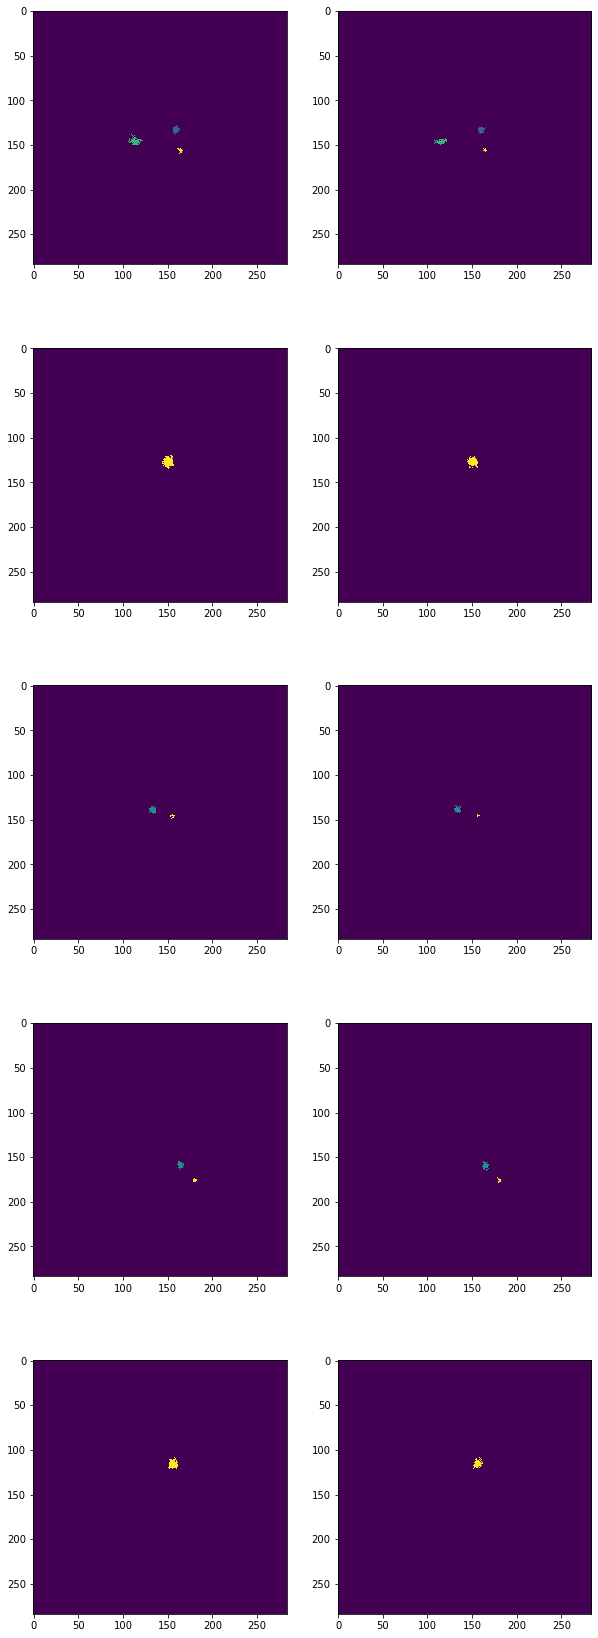

In [89]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 30))
i = 0
for parsed_record in dataset.take(5):
#     plt.imshow(parsed_record['image'][:,:,0])
#     plt.colorbar()
#     print(parsed_record['labels'])
    output = cluster_maker(parsed_record)
    A = output['proto'].numpy()
    A1 = A[A[...,3] == 0][...,:3]
    A2 = A[A[...,3] == 1][...,:3]
    # A1 = np.unique(A1, axis=0)
    # A2 = np.unique(A2, axis=0)
    # print(A1)
    sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[HEIGHT,WIDTH])
    A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
    sp = tf.SparseTensor(A2[...,1:3], A2[...,0], dense_shape=[HEIGHT,WIDTH])
    A2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
    ax[i][0].imshow(A1_dense)
    ax[i][1].imshow(A2_dense)
    
    output2 = cluster_splitter(output)
#     A = output['cluster'].numpy()
#     A1 = A[A[...,3] == 0][...,:3]
#     A2 = A[A[...,3] == 1][...,:3]
# #     # A1 = np.unique(A1, axis=0)
# #     # A2 = np.unique(A2, axis=0)


    u = np.unique(A1[:,0])
    print(u)
    
#     sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[HEIGHT,WIDTH])
#     A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
#     ax[i][1].imshow(A1_dense)
    
    i += 1
    print("eventId", parsed_record['eventId'])

# Topological Clustering

Groups neighboring cells of significant energy into clusters with a variable number of cells (vs sliding-window algorithm). Cluster growth starts at seed cells, i.e. cells with significance above $t_\text{seed}$ (high). Neighboring cells become new seeds if their significance are above $t_\text{neighbor}$ (medium). If a neighboring cell has significance only above $t_\text{cell}$ (low) it is simply added to the cluster without functioning as a seed. The low threshold means shower tails are not discarded, the other thresholds supress noise. This algorithm consists of two steps: the cluster maker and the cluster splitter.

## Cluster maker

Forms topological clusters from cells and consists of the following steps:

* **Finding seeds**: seed list consists of cells with significance above $t_\text{seed}$. Neighboring seed cells form initial proto-clusters (vs paper where each seed cell forms a proto-cluster) - possibly look at later. NB missing noise!
* **Finding neighbors**: current seed list ordered in descending order in significance. Consider neighboring cells of each seed cell in turn: a) if significance above $t_\text{neighbor}$ it is added to the neighbor seed list and adjacent proto-cluster; if adjacent to multiple proto-clusters, these are merged. b) if significance only above $t_\text{cell}$ cell included only in first adjacent proto-cluster (which has the more significant neighbor due to the sorting), not in the neighbor seed list (it is unclear from the paper if the latter is true). When all seed cells have been processed, the neighbor seed list becomes the new seed list. This procedure of neighbor finding is repeated until the seed list is empty.
* **Finalize**: resulting proto-clusters are sorted in descending order in $E_T$ and filtered $E_T>t_\text{energy}$ - does $E_T$ refer to transverse energy or total energy or total energy above threshold?  

"Neighboring" is here defined as the eight surronding cells within the same channel and overlapping cells in adjacent channels. The scintillating and Cerenkov signals are treated as two different channels, consequently, each cell has nine neighbors. 

### Finding seeds

In [81]:
# from skimage.measure import label
import skimage
from skimage import measure

f = lambda x: skimage.measure.label(x, connectivity=2)

def finding_seeds(image):
    """Finding seeds and create seed list"""
    seed_mask = tf.math.greater(image, TSEED)
    labels = tf.numpy_function(f, [seed_mask], Tout=tf.int64)
    seed_idx = tf.where(tf.not_equal(labels, 0))
    seed_id = tf.expand_dims(tf.gather_nd(labels, seed_idx), axis=1)
    seed_list = tf.concat([seed_id, seed_idx], axis=-1)
    return seed_list

### Finding neighbors

In [18]:
def sorting_seedlist(seed_list, seed_len, image):
    """Sorts current seed list in descending order"""
    seed_id, seed_idx = tf.split(seed_list, num_or_size_splits=[1,3], axis=1)
    seeds = tf.gather_nd(image, seed_idx)
    values, indices = tf.math.top_k(seeds, k=seed_len)
    return tf.gather(seed_list, indices)

In [19]:
def neighbors(index, excl=tf.zeros([0, 3], tf.int64), incl=tf.zeros([0, 3], tf.int64)):
    """8-1 connectivity"""
    
    # indices of 3x3x1 centred at (i,j,k)
    i, j, k = tf.unstack(index)
    ii, jj = tf.meshgrid(tf.range(i-1, i+2), tf.range(j-1, j+2), indexing='ij')
    ii = tf.reshape(ii, [-1, 1])
    jj = tf.reshape(jj, [-1, 1])
    kk = tf.repeat(tf.reshape(k, (1, 1)), repeats=[9], axis=0)
    a = tf.concat([ii, jj, kk], axis=-1)
    
    # append index (i,j) in other k channel
    a = tf.concat([a, [[i, j, tf.math.abs(k-1)]]], axis=0)
    
    # remove centre point (i,j,k)
    mask_centre = tf.reduce_any(tf.not_equal(a, index), axis=-1)
    
    # remove points outside image
    b = tf.expand_dims(a, axis=-1)
    c = tf.transpose(tf.constant([[HEIGHT,-1, -1], [-1,WIDTH,-1]], dtype=b.dtype))
    mask_boundary = tf.reduce_all(tf.not_equal(b, c), axis=[-2,-1])
    mask = tf.logical_and(mask_centre, mask_boundary)
    a = tf.boolean_mask(a, mask)
    
    # remove points in excl and only consider points in incl
    a_sp = tf.SparseTensor(a, tf.ones(tf.shape(a)[0], dtype=tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    a_d = tf.sparse.to_dense(tf.sparse.reorder(a_sp))
    excl_sp = tf.SparseTensor(excl, tf.ones(tf.shape(excl)[0], dtype=tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    excl_d = tf.sparse.to_dense(tf.sparse.reorder(excl_sp))
    incl_sp = tf.SparseTensor(incl, tf.ones(tf.shape(incl)[0], dtype=tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    incl_d = tf.sparse.to_dense(tf.sparse.reorder(incl_sp))
    mask_final = tf.logical_and(a_d, tf.logical_not(excl_d))
    
    true_fn = lambda: tf.logical_and(mask_final, incl_d)
    mask_final = tf.cond(tf.greater(tf.shape(incl)[0], 0), true_fn, lambda: mask_final)
    
    neighbors = tf.where(mask_final)
    return neighbors

In [47]:
def merge_adjacent_proto(nj, siid, m, p, s, l):
    """Merge adjacent proto-clusters"""
    sid, sidx = tf.split(s, num_or_size_splits=[1,3], axis=1)
    lid, lidx = tf.split(l, num_or_size_splits=[1,3], axis=1)
    proto_id, proto_idx = tf.split(p, num_or_size_splits=[1,3], axis=1)
    nnj = neighbors(nj, excl=sidx)
    nnj_sp = tf.SparseTensor(nnj, tf.ones(tf.shape(nnj)[0], tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    nnj_d = tf.sparse.to_dense(tf.sparse.reorder(nnj_sp))
    proto_sp = tf.SparseTensor(proto_idx, tf.reshape(proto_id, [-1,]), dense_shape=[HEIGHT, WIDTH, 2])
    proto_d = tf.sparse.to_dense(tf.sparse.reorder(proto_sp))
    indices = tf.where(tf.logical_and(tf.logical_and(nnj_d, tf.not_equal(proto_d, 0)), tf.greater(m, TNEIGHBOR)))
#     indices = tf.where(tf.logical_and(nnj_d, tf.not_equal(proto_d, 0)))
    values = tf.gather_nd(proto_d, indices)
    values = tf.boolean_mask(values, tf.not_equal(values, siid))
    
    # loop over values
    k0 = tf.constant(0)
    ck = lambda k, p, s, l: tf.less(k, tf.shape(values)[0])
    def bk(k, p, s, l):
        neigh_id = tf.gather(values, k)
        pnew = tf.where(tf.equal(proto_d, neigh_id), tf.reshape(siid, [-1,])*tf.ones_like(p), p)
        snew = tf.where(tf.equal(sid, neigh_id), tf.reshape(siid, [-1,])*tf.ones_like(s), s)
        lnew = tf.where(tf.equal(lid, neigh_id), tf.reshape(siid, [-1,])*tf.ones_like(l), l)
        return [tf.add(k, 1), pnew, snew, lnew]
    k, p, sid, lid = tf.while_loop(ck, bk, loop_vars=[k0, proto_d, sid, lid],
                                   shape_invariants=[k0.get_shape(), proto_d.get_shape(),
                                                     sid.get_shape(), lid.get_shape()])                
    indices = tf.where(tf.not_equal(p, 0))
    values = tf.expand_dims(tf.gather_nd(p, indices), axis=1)
    pnew = tf.concat([values, indices], axis=1)
    snew = tf.concat([sid, sidx], axis=1)
    lnew = tf.concat([lid, lidx], axis=1)
    return [pnew, snew, lnew]


def bj_maker(j, m, p, s, l, n, siid):
    """Body of while loop over neighbors"""
    nj = tf.gather(n, j)
    nval = tf.gather_nd(m, nj)
    nnew = tf.expand_dims(tf.concat([siid, nj], axis=0), axis=0)

    def tneighbor(siid=siid):
        """Append cells to both proto-clusters and neighbor seed list if value above TNEIGHBOR"""
        [pnew, snew, lnew] = merge_adjacent_proto(nj, siid, m, p, s, l)
        pnew = tf.concat([pnew, nnew], axis=0)
        lnew = tf.concat([lnew, nnew], axis=0)
        return [pnew, snew, lnew]

    def tcell():
        """Append cells to proto-clusters if value above TCELL"""
        def true_fn():
            return tf.concat([p, nnew], axis=0)
        def false_fn(): return p
        pnew = tf.cond(tf.greater(nval, TCELL), true_fn, false_fn)
        return [pnew, s, l]
    
    [pnew, snew, lnew] = tf.cond(tf.greater(nval, TNEIGHBOR), true_fn=tneighbor, false_fn=tcell)
    
    return [tf.add(j, 1), m, pnew, snew, lnew, n, siid]
    

def bi_maker(i, m, p, s, l):
    """Body of while loop over current seed list"""
    si = tf.gather(s, i)
    
    # find neighbours not in protolist
    siid, siidx = tf.split(si, num_or_size_splits=[1,3], axis=0)
    _, pidx = tf.split(p, num_or_size_splits=[1,3], axis=1)
    n = neighbors(siidx, excl=pidx)
        
    # loop over neighbors
    j0 = tf.constant(0)
    cj = lambda j, m, p, s, l, n, siid: tf.less(j, tf.shape(n)[0])
    _, m, p, s, l, _, _ = tf.while_loop(
        cj, bj_maker, loop_vars=[j0, m, p, s, l, n, siid],
        shape_invariants=[j0.get_shape(), m.get_shape(), tf.TensorShape([None, 4]),
                          s.get_shape(), tf.TensorShape([None, 4]),
                          n.get_shape(), siid.get_shape()])
    
    return [tf.add(i, 1), m, p, s, l]
  
def finding_neighbors_maker(m, p, s):
    """Finding neighbors recursively until current seed list is empty.
    m: image, p: protolist, s: seedlist, l: neighlist, n: neighbor"""
    slen = tf.shape(s)[0]
    
    # sort current seed list in descending order
    s = sorting_seedlist(s, slen, m)
    
    # loop over current seed list
    i0, l0 = tf.constant(0), tf.zeros([0,4], tf.int64)
    ci = lambda i, m, p, s, l: tf.less(i, slen)
    _, m, pnew, s, lnew = tf.while_loop(
        ci, bi_maker, loop_vars=[i0, m, p, s, l0],
        shape_invariants=[i0.get_shape(), m.get_shape(), tf.TensorShape([None, 4]),
                          s.get_shape(), tf.TensorShape([None, 4])])
    # neighbor seed list becomes the new seed list
    snew = lnew
        
    # repeated until current seed list is empty
    def true_fn(): return finding_neighbors_maker(m, pnew, snew)
    def false_fn(): return pnew
#     print("ciao", tf.size(snew))
    pnew = tf.cond(tf.not_equal(tf.size(snew), tf.constant(0)), true_fn, false_fn)
    return pnew

### Finalize cluster maker

In [21]:
def renumber_proto(s):
    sid, sidx = tf.split(s, num_or_size_splits=[1,3], axis=1)
    u, uid = tf.unique(tf.reshape(sid, [-1]), out_idx=sid.dtype)
    ulen = tf.shape(u)[0]
    uid = tf.reshape(tf.add(uid, 1), [-1,1])
    s = tf.concat([uid, sidx], axis=1)
    return s

In [43]:
def finalize_maker(m, s):
    """Finalize cluster maker by removing clusters with energy 
    less than TENERGY and sort in descending order in energy"""
    
    # compute total cluster energy
    sid, sidx = tf.split(s, num_or_size_splits=[1,3], axis=1)
    u, uid = tf.unique(tf.reshape(sid, [-1]), out_idx=sid.dtype)
    ulen = tf.shape(u)[0]
    uid = tf.reshape(tf.add(uid, 1), [-1,1])
    s = tf.concat([uid, sidx], axis=1)
    
    s_sp = tf.SparseTensor(sidx, tf.reshape(uid, [-1,]), dense_shape=[HEIGHT, WIDTH, 2])
    s_dense = tf.sparse.to_dense(tf.sparse.reorder(s_sp))
    i0 = tf.constant(1, s_dense.dtype)
    E0 = tf.constant([], m.dtype)
    c = lambda i, E: tf.less(i, tf.cast(ulen+1, s_dense.dtype))
    def b(i, E):
        indices = tf.where(tf.equal(s_dense, i))
        values = tf.gather_nd(m, indices)
        Ei = tf.expand_dims(tf.reduce_sum(values), axis=0)
        return [tf.add(i, 1), tf.concat([E, Ei], axis=0)]
    _, E = tf.while_loop(c, b, loop_vars=[i0, E0], shape_invariants=[i0.get_shape(), tf.TensorShape([None, 1])])
    print("total cluster energy", E)
    
    # sort in descending order in energy and remove clusters with energy less than TENERGY
    values, indices = tf.math.top_k(E, k=ulen)
    indices = tf.cast(tf.add(indices, 1), s_dense.dtype)
    indices = tf.boolean_mask(indices, tf.greater(values, TENERGY))
    i0 = tf.constant(0)
    p0 = tf.zeros_like(s_dense)
    c = lambda i, p: tf.less(i, tf.shape(indices)[0])
    def b(i, p):
        ii = tf.gather(indices, i)
        pnew = tf.add(p, tf.where(tf.equal(s_dense, ii), s_dense, tf.zeros_like(s_dense)))
        return [tf.add(i, 1), pnew]
    _, p = tf.while_loop(c, b, loop_vars=[i0, p0], shape_invariants=[i0.get_shape(), p0.get_shape()])
    sidx = tf.where(tf.not_equal(p, 0))
    sid = tf.expand_dims(tf.gather_nd(p, sidx), axis=1)
    s = tf.concat([sid, sidx], axis=1)
    
    s = renumber_proto(s)
    
    return s

### Cluster maker

In [25]:
def cluster_maker(parsed):
    print('hello')
    image = parsed['image']
    
    seedlist = finding_seeds(image)
    seedlist = finding_neighbors_maker(image, seedlist, seedlist)
    seedlist = finalize_maker(image, seedlist)
    
    parsed['proto'] = seedlist 
    return parsed

In [19]:
# test skimage.measure.label
seed_mask = np.zeros([3,3,2])
seed_mask[1,1,0] = 1
seed_mask[2,2,0] = 1
seed_mask[2,2,1] = 2
seed_mask[0,0,1] = 1
print(seed_mask)
print(label(seed_mask, return_num=True, connectivity=2))

NameError: name 'np' is not defined

## Cluster splitter

The cluster maker is sufficient for isolated signals, but not for overlapping showers. If individual particles form local maxima they may still be separable. Acting on the clusters resulting from the cluster maker, this is what the cluster splitter does in the followning steps:

* **Finding local maxima**: a local maxima is defined as a cell with: a) $E>t_\text{locmax}$, b) energy greater than that of any neighboring cell, and c) number of neighboring cells withing the parent cluster $N>t_\text{number}$ (default is $\geq4$). Each local maximum forms a cluster and parent clusters without any local maximum cell will not be split.
* **Finding neighbors**: the local maxima now becomes the initial seed list much like in cluster maker, except that only cells originally clustered are used, without thresholding and merging. Instead of merging, shared cells are added to a shared cell list to be handled separately.
* **Shared cells**: the shared cell list is expanded iteratively adding neighbors from the originally clustered cells not yet assigned to any proto-cluster. Each of these are then added to the two adjoining proto-clusters with the weights $w_1=\frac{E_{1}}{E_{1}+rE_{2}}, w_{2}=1-w_{1}, r=\exp(d_{1}-d_{2})$, where $E_{1,2}$ are the energies of the two proto-clusters and $d_{1,2}$ are the distances of the shared cell to the proto-cluster centroids in units of a typical em shower scale.
* **Finalize**:

### Finding local maxima

In [35]:
def finding_local_maxima(m, p):
    """Find local maxima cells by looping over protolist.
    m: filtered image, x: local maxima"""
    
    # loop over protolist
    i0 = tf.constant(0)
    x = tf.zeros([0, 4], p.dtype)
    c = lambda i, p, x: tf.less(i, tf.shape(p)[0])
    def b(i, p, x):
        pi = tf.gather(p, i)
        piid, piidx = tf.split(pi, num_or_size_splits=[1,3], axis=0)
        pval = tf.gather_nd(m, piidx)
        midx = tf.where(tf.greater(m, 0))
        nidx = neighbors(piidx, incl=midx)
        m_val = tf.gather_nd(m, nidx)
#         m_val = tf.boolean_mask(m_val, tf.greater(m_val, 0))

        pred = tf.logical_and(tf.logical_and(tf.greater(pval, TLOCMAX), 
                                      tf.greater(pval, tf.math.reduce_max(m_val))),
                                      tf.greater(m_val.get_shape()[0], TNUMBER))
        r = tf.cond(pred, lambda: tf.expand_dims(pi, axis=0), lambda: tf.zeros([0, 4], pi.dtype))
        
        return [tf.add(i, 1), p, tf.concat([x, r], axis=0)]
    
    _, p, x = tf.while_loop(
        c, b, loop_vars=[i0, p, x], 
        shape_invariants=[i0.get_shape(), p.get_shape(), tf.TensorShape([None, 4])])
    
    return x

### Finding neighbors

In [44]:
def is_shared(nj, p, siid):
    nnj = neighbors(nj)
    proto_id, proto_idx = tf.split(p, num_or_size_splits=[1,3], axis=1)
    nnj_sp = tf.SparseTensor(nnj, tf.ones(tf.shape(nnj)[0], tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    nnj_d = tf.sparse.to_dense(tf.sparse.reorder(nnj_sp))
    proto_sp = tf.SparseTensor(proto_idx, tf.reshape(proto_id, [-1,]), dense_shape=[HEIGHT, WIDTH, 2])
    proto_d = tf.sparse.to_dense(tf.sparse.reorder(proto_sp))
    indices = tf.where(tf.logical_and(nnj_d, tf.not_equal(proto_d, 0)))
    values = tf.gather_nd(proto_d, indices)
    y, idx = tf.unique(values)
    return [y, tf.equal(y.get_shape()[0], 2)]

def bj_splitter(j, m, p, s, l, o, n, siid):
    """Body of while loop over neighbors"""
    nj = tf.gather(n, j)
    
    ids, pred = is_shared(nj, p, siid)
    
    def true_fn():
        nnew = tf.expand_dims(tf.concat([ids, nj], axis=0), axis=0)
        onew = tf.concat([o, nnew], axis=0)
        return [p, s, l, onew]
    def false_fn():
        nnew = tf.expand_dims(tf.concat([siid, nj], axis=0), axis=0)
        pnew = tf.concat([p, nnew], axis=0)
        lnew = tf.concat([l, nnew], axis=0)
        return [pnew, s, lnew, o]

    [pnew, snew, lnew, onew] = tf.cond(pred, true_fn, false_fn)
        
    return [tf.add(j, 1), m, pnew, snew, lnew, onew, n, siid]

def bi_splitter(i, m, p, s, l, o):
    """Body of while loop over current seed list"""
    si = tf.gather(s, i)
    
    # find neighbours not in protolist and only include cells originally clustered
    siid, siidx = tf.split(si, num_or_size_splits=[1,3], axis=0)
    _, pidx = tf.split(p, num_or_size_splits=[1,3], axis=1)
    _, oidx = tf.split(o, num_or_size_splits=[2,3], axis=1)
    midx = tf.where(tf.greater(m, 0))
    
    n = neighbors(siidx, excl=tf.concat([pidx, oidx], axis=0), incl=midx)
    
    # loop over neighbors
    j0 = tf.constant(0)
    cj = lambda j, m, p, s, l, o, n, siid: tf.less(j, n.get_shape()[0])
    _, m, p, s, l, o, _, _ = tf.while_loop(
        cj, bj_splitter, loop_vars=[j0, m, p, s, l, o, n, siid],
        shape_invariants=[j0.get_shape(), m.get_shape(), tf.TensorShape([None, 4]),
                          s.get_shape(), tf.TensorShape([None, 5]), tf.TensorShape([None, 4]),
                          n.get_shape(), siid.get_shape()])
    
    return [tf.add(i, 1), m, p, s, l, o]

def finding_neighbors_splitter(m, p, s, o):
    """Finding neighbors recursively until current seed list is empty.
    m: image, p: protolist, s: seedlist, l: neighlist, n: neighbor, o: sharedlist"""
    slen = tf.shape(s)[0]
    
    # sort current seed list in descending order
    s = sorting_seedlist(s, slen, m)
    
    # loop over current seed list
    i0, l0 = tf.constant(0), tf.zeros([0,4], tf.int64)
    ci = lambda i, m, p, s, l, o: tf.less(i, slen)
    _, m, pnew, s, lnew, onew = tf.while_loop(
        ci, bi_splitter, loop_vars=[i0, m, p, s, l0, o],
        shape_invariants=[i0.get_shape(), m.get_shape(), 
                          tf.TensorShape([None, 4]), s.get_shape(),
                          tf.TensorShape([None, 4]), tf.TensorShape([None, 5])])
    
    # neighbor seed list becomes the new seed list
    snew = lnew
    
    # repeated until current seed list is empty
    def true_fn(): return finding_neighbors_splitter(m, pnew, snew, onew)
    def false_fn(): return [pnew, onew]
    [pnew, onew] = tf.cond(tf.not_equal(tf.size(snew), 0), true_fn, false_fn)
    return [pnew, onew]

### Shared cells

In [45]:
def bj_shared(j, p, l, n, siid):
    """Body of while loop over neighbors"""
    nj = tf.gather(n, j)
    nnew = tf.expand_dims(tf.concat([siid, nj], axis=0), axis=0)
    pnew = tf.concat([p, nnew], axis=0)
    lnew = tf.concat([l, nnew], axis=0)
    return [tf.add(j, 1), pnew, lnew, n, siid]

def bi_shared(i, m, p, s, l):
    """Body of while loop over current seed list"""
    si = tf.gather(s, i)
    
    # find neighbours not in protolist and only include cells originally clustered
    siid, siidx = tf.split(si, num_or_size_splits=[2,3], axis=0)
    _, pidx = tf.split(p, num_or_size_splits=[2,3], axis=1)
    midx = tf.where(m)
    
    n = neighbors(siidx, excl=pidx, incl=midx)
    
    # loop over neighbors
    j0 = tf.constant(0)
    cj = lambda j, p, l, n, siid: tf.less(j, n.get_shape()[0])
    _, p, l, _, _ = tf.while_loop(
        cj, bj_shared, loop_vars=[j0, p, l, n, siid],
        shape_invariants=[j0.get_shape(), tf.TensorShape([None, 5]), tf.TensorShape([None, 5]),
                          n.get_shape(), siid.get_shape()])
    
    return [tf.add(i, 1), m, p, s, l]

def expand_sharedlist(m, p, s):
    # loop over current seed list
    i0, l0 = tf.constant(0), tf.zeros([0,5], s.dtype)
    ci = lambda i, m, p, s, l: tf.less(i, s.get_shape()[0])
    _, _, pnew, s, lnew = tf.while_loop(
        ci, bi_shared, loop_vars=[i0, m, p, s, l0],
        shape_invariants=[i0.get_shape(), m.get_shape(), tf.TensorShape([None, 5]), 
                          s.get_shape(), tf.TensorShape([None, 5])])
    
    # neighbor seed list becomes the new seed list
    snew = lnew
    
    # repeated until current seed list is empty
    def true_fn(): return expand_sharedlist(m, pnew, snew)
    def false_fn(): return pnew
    slen = snew.get_shape()[0]
    pnew = tf.cond(tf.greater(slen, 0), true_fn, false_fn)
    return pnew

### Finalize cluster splitter

In [51]:
def finalize_splitter(m, p, o):
    pid, pidx = tf.split(p, num_or_size_splits=[1,3], axis=1)
    pval = tf.gather_nd(m, pidx)
    psp = tf.SparseTensor(pidx, tf.reshape(pid, [-1,]), dense_shape=[HEIGHT, WIDTH, 2])
    pd = tf.sparse.to_dense(tf.sparse.reorder(psp))
    pnew = tf.concat([tf.cast(pid, pval.dtype), tf.cast(pidx, pval.dtype), tf.expand_dims(pval, axis=1)], axis=1)
    
    y = tf.unique(tf.reshape(pid, [-1,]))[0]
    print("unique pid", y)
    
    i0, com0, E0 = tf.constant(0), tf.zeros([0, 3], m.dtype), tf.zeros([0, 1], m.dtype)
    ci = lambda i, com, E: tf.less(i, y.get_shape()[0])
    def bi(i, com, E):
        yi = tf.gather(y, i)
        indices = tf.where(tf.equal(pd, yi))
        values = tf.expand_dims(tf.gather_nd(m, indices), axis=1)
        indices = tf.cast(indices, values.dtype)
        comi = tf.reduce_sum(tf.multiply(indices, values), axis=0)
        Ei = tf.reduce_sum(values)
        comi = tf.divide(comi, Ei)
        comi = tf.expand_dims(comi, axis=0)
        Ei = tf.reshape(Ei, [-1,1])
        return [tf.add(i, 1), tf.concat([com, comi], axis=0), tf.concat([E, Ei], axis=0)]
    _, com, E = tf.while_loop(
        ci, bi, loop_vars=[i0, com0, E0],
        shape_invariants=[i0.get_shape(), tf.TensorShape([None, 3]), tf.TensorShape([None, 1])])
#     print(com, E)
    
    j0, l0 = tf.constant(0), tf.zeros([0, 5], m.dtype)
    cj = lambda j, l: tf.less(j, o.get_shape()[0])
    def bj(j, l):
        oj = tf.gather(o, j)
        a, b, ojidx = tf.split(oj, num_or_size_splits=[1,1,3], axis=0)
        oval = tf.expand_dims(tf.gather_nd(m, ojidx), axis=0)
        ojidx = tf.cast(ojidx, com.dtype)
        amask = tf.equal(y, a)
        bmask = tf.equal(y, b)
        acom = tf.reshape(tf.boolean_mask(com, amask), [-1,])
        bcom = tf.reshape(tf.boolean_mask(com, bmask), [-1,])
        d1 = tf.sqrt(tf.reduce_sum(tf.math.squared_difference(ojidx, acom)))
        d2 = tf.sqrt(tf.reduce_sum(tf.math.squared_difference(ojidx, bcom)))
        # missing in units of !
        r = tf.exp(tf.subtract(d1, d2))
        E1 = tf.boolean_mask(E, amask)
        E2 = tf.boolean_mask(E, bmask)
        w1 = tf.reshape(tf.divide(E1, tf.add(E1, tf.multiply(r, E2))), [-1,])
        w2 = tf.subtract(1, w1)
        la = tf.expand_dims(tf.concat([tf.cast(a, com.dtype), ojidx, tf.multiply(w1, oval)], axis=0), axis=0)
        lb = tf.expand_dims(tf.concat([tf.cast(b, com.dtype), ojidx, tf.multiply(w2, oval)], axis=0), axis=0)
        return [tf.add(j, 1), tf.concat([l, la, lb], axis=0)]
    _, lnew = tf.while_loop(
        cj, bj, loop_vars=[j0, l0],
        shape_invariants=[j0.get_shape(), tf.TensorShape([None, 5])])

    pnew = tf.concat([pnew, lnew], axis=0)

    # sort in descending order in energy 
    indices = tf.reshape(tf.cast(tf.math.top_k(tf.reshape(E, [1, -1]), k=E.get_shape()[0])[1], o.dtype), [-1,])
#     print(y, indices)
    
    k0, p0 = tf.constant(0), tf.zeros([0, 5], pnew.dtype)
    ck = lambda k, p: tf.less(k, pnew.get_shape()[0])
    def bk(k, p):
        pk = tf.gather(pnew, k)
        pkid, pkidx = tf.split(pk, num_or_size_splits=[1,4], axis=0)
        yidx = tf.reshape(tf.where(tf.equal(y, tf.cast(pkid, y.dtype))), [-1,])
        pkid = tf.cast(tf.add(tf.where(tf.equal(indices, yidx)), 1), pkidx.dtype)
        pknew = tf.concat([pkid, tf.expand_dims(pkidx, axis=0)], axis=1)
        return [tf.add(k, 1), tf.concat([p, pknew], axis=0)]
    pnew = tf.while_loop(ck, bk, [k0, p0])[1]
    
    return pnew

### Cluster splitter

In [52]:
def cluster_splitter(parsed):    
    proto = parsed['proto']
    image = parsed['image']
#     image = tf.constant(image)
    
    # filter image with protolist
    proto_id, proto_idx = tf.split(proto, num_or_size_splits=[1,3], axis=1)
    proto_val = tf.gather_nd(image, proto_idx)
    image_sp = tf.SparseTensor(proto_idx, proto_val, dense_shape=[HEIGHT, WIDTH, 2])
    image_d = tf.sparse.to_dense(tf.sparse.reorder(image_sp))
    
    locmax = finding_local_maxima(image_d, proto)
    
    # create seed list from local maxima
    _, locmax_idx = tf.split(locmax, num_or_size_splits=[1,3], axis=1)
    proto_sp = tf.SparseTensor(proto_idx, tf.reshape(proto_id, [-1,]), dense_shape=[HEIGHT, WIDTH, 2])
    proto_d = tf.sparse.to_dense(tf.sparse.reorder(proto_sp))
    start = tf.add(tf.reduce_max(proto_id), 1)
    limit = start + locmax.get_shape()[0]
    locmax_id = tf.expand_dims(tf.range(start, limit, dtype=locmax.dtype), axis=1)
    seedlist = tf.concat([locmax_id, locmax_idx], axis=1)
    sharedlist = tf.zeros([0,5], tf.int64)
    
    [protolist, sharedlist] = finding_neighbors_splitter(image_d, seedlist, seedlist, sharedlist)
    
    # originally clustered cells not in protolist
    protolist_id, protolist_idx = tf.split(protolist, num_or_size_splits=[1,3], axis=1)
    protolist_sp = tf.SparseTensor(protolist_idx, tf.reshape(protolist_id, [-1,]), dense_shape=[HEIGHT, WIDTH, 2])
    protolist_d = tf.sparse.to_dense(tf.sparse.reorder(protolist_sp))
    mask = tf.logical_and(tf.cast(proto_d, tf.bool), tf.logical_not(tf.cast(protolist_d, tf.bool)))
    
    sharedlist = expand_sharedlist(mask, sharedlist, sharedlist)
    
    # add parent clusters without a local maximum
    mask = tf.logical_and(tf.cast(proto_d, tf.bool), tf.cast(protolist_d, tf.bool))
    proto_y = tf.expand_dims(tf.unique(tf.reshape(proto_id, [-1,]))[0], axis=0)
    proto_masked_y = tf.expand_dims(tf.unique(tf.boolean_mask(proto_d, mask))[0], axis=0)
    other = tf.sparse.to_dense(tf.sets.difference(proto_y, proto_masked_y))

    other = tf.reshape(other, [-1,1])
    
    if tf.not_equal(tf.size(other), 0):
        i = tf.constant(0)
        c = lambda i, p: tf.less(i, tf.shape(other)[0])
        def b(i, p): 
            otheri = tf.gather(other, i)
            p = tf.where(tf.equal(proto_d, otheri), proto_d, p) 
            return [tf.add(i, 1), p]
        protolist_d = tf.while_loop(c, b, [i, protolist_d])[1]
        pidx = tf.where(protolist_d)
        pid = tf.expand_dims(tf.gather_nd(protolist_d, pidx), axis=1)
        protolist = tf.concat([pid, pidx], axis=1)
    
    cluster = finalize_splitter(image_d, protolist, sharedlist)
        
    parsed['cluster'] = cluster
    
    return parsed

In [137]:
def scalar_features(parsed):
    cluster = parsed['cluster']
    
    pid, pidx, pval = tf.split(cluster, num_or_size_splits=[1,3,1], axis=1)    
    y = tf.unique(tf.reshape(pid, [-1,]))[0]
    print("unique pid", y)
    
    yi = tf.gather(y, 0)
#     indices = tf.where(tf.equal(pid, yi))
#     print(tf.gather(pidx, indices))
    
#     print(cluster)
    

## Run

## Toy example

In [126]:
HEIGHT = 20
WIDTH = 20
TENERGY = 10e3
TLOCMAX = 100
TNUMBER = 3
# good values to test if recursive function works
TSEED = tf.constant(1000, tf.float32)  # tf.constant([300.], tf.float32)
TNEIGHBOR = tf.constant(100., tf.float32)
TCELL = tf.constant(50., tf.float32)

(20, 20, 2)

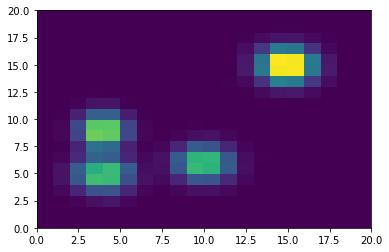

In [127]:
import numpy as np
import matplotlib.pyplot as plt 
X = np.vstack((np.random.multivariate_normal(mean=[2+2,3+2], cov=[[1,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[2+2,7+2], cov=[[0.7,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[8+2,4+2], cov=[[1,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[15,15], cov=[[1,0],[0,1]], size=15000)))
A = plt.hist2d(X[:,0], X[:,1], bins=HEIGHT, range=[[0, HEIGHT], [0, WIDTH]])[0]
# plt.imshow(A)
# B = A[..., np.newaxis]
A[:2,6] = 1.5*TNEIGHBOR
A[0,7:9] = 1.5*TCELL
A[1,5] = 0
A[3,16] = 20*TSEED

B = np.stack((A,0.5*A), axis=-1).astype(np.float32)
np.shape(B)

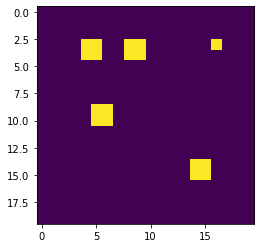

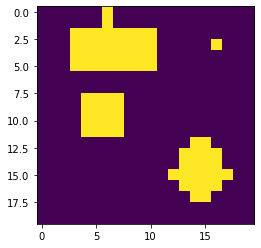

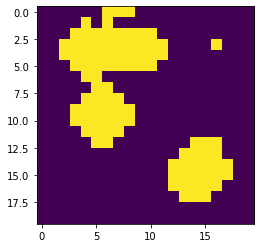

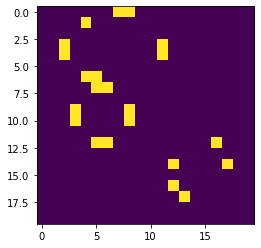

In [128]:
plt.imshow(A > TSEED)
plt.show()
plt.imshow(A > TNEIGHBOR)
plt.show()
plt.imshow(A > TCELL)
plt.show()
plt.imshow((A > TCELL) & (A <= TNEIGHBOR))
plt.show()

In [129]:
output = cluster_maker({'image': tf.constant(B)})

hello
total cluster energy tf.Tensor([29500.  30000.  14232.5 21844.5], shape=(4,), dtype=float32)


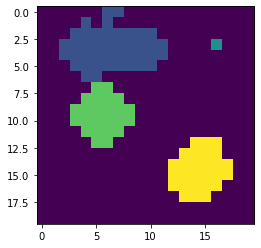

In [130]:
A = output['proto'].numpy()
# print(A)
# A = A[...,1:]
A1 = A[A[...,3] == 0][...,:3]
A2 = A[A[...,3] == 1][...,:3]
# A1 = np.unique(A1, axis=0)
# A2 = np.unique(A2, axis=0)
# print(A1)

sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[HEIGHT,WIDTH])
A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(A1_dense)

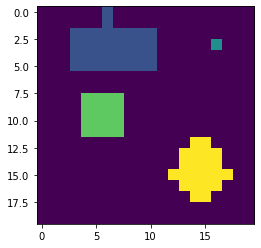

In [131]:
sp = tf.SparseTensor(A2[...,1:3], A2[...,0], dense_shape=[HEIGHT,WIDTH])
A2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(A2_dense)

In [132]:
# output2['cluster']

In [133]:
# output = cluster_maker({'image': B})
output2 = cluster_splitter(output)
# output2

unique pid tf.Tensor([5 6 2 7 8], shape=(5,), dtype=int64)


In [138]:
scalar_features(output2)

unique pid tf.Tensor([5. 3. 1. 4. 2.], shape=(5,), dtype=float32)
tf.Tensor(
[[[1. 4. 0.]
  [1. 4. 0.]]

 [[2. 3. 0.]
  [1. 4. 0.]]

 [[2. 3. 1.]
  [1. 4. 0.]]

 [[2. 4. 0.]
  [1. 4. 0.]]

 [[2. 4. 1.]
  [1. 4. 0.]]

 [[2. 5. 0.]
  [1. 4. 0.]]

 [[2. 5. 1.]
  [1. 4. 0.]]

 [[3. 2. 0.]
  [1. 4. 0.]]

 [[3. 3. 0.]
  [1. 4. 0.]]

 [[3. 3. 1.]
  [1. 4. 0.]]

 [[3. 4. 0.]
  [1. 4. 0.]]

 [[3. 4. 1.]
  [1. 4. 0.]]

 [[3. 5. 0.]
  [1. 4. 0.]]

 [[3. 5. 1.]
  [1. 4. 0.]]

 [[4. 2. 0.]
  [1. 4. 0.]]

 [[4. 3. 0.]
  [1. 4. 0.]]

 [[4. 3. 1.]
  [1. 4. 0.]]

 [[4. 4. 0.]
  [1. 4. 0.]]

 [[4. 4. 1.]
  [1. 4. 0.]]

 [[4. 5. 0.]
  [1. 4. 0.]]

 [[4. 5. 1.]
  [1. 4. 0.]]

 [[5. 3. 0.]
  [1. 4. 0.]]

 [[5. 3. 1.]
  [1. 4. 0.]]

 [[5. 4. 0.]
  [1. 4. 0.]]

 [[5. 4. 1.]
  [1. 4. 0.]]

 [[5. 5. 0.]
  [1. 4. 0.]]

 [[5. 5. 1.]
  [1. 4. 0.]]

 [[3. 6. 0.]
  [1. 4. 0.]]

 [[4. 6. 0.]
  [1. 4. 0.]]

 [[5. 6. 0.]
  [1. 4. 0.]]

 [[2. 6. 0.]
  [1. 4. 0.]]

 [[1. 6. 0.]
  [1. 4. 0.]]

 [[3. 6. 1.]
  [1. 4. 0.]]


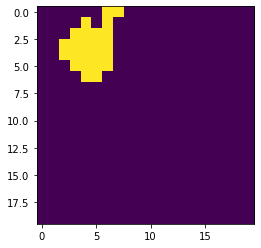

In [90]:
C = output2['cluster'].numpy()
# plt.
# print(A)
# A = A[...,1:]
C1 = C[C[...,3] == 0][...,:3]
C2 = C[C[...,3] == 1][...,:3]
C1 = C1[C1[...,0] == 5]
# C1 = np.unique(C1, axis=0)
# C2 = np.unique(C2, axis=0)
# print(A1)

sp = tf.SparseTensor(C1[...,1:3], C1[...,0], dense_shape=[HEIGHT,WIDTH])
C1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C1_dense)

In [136]:
C = output2['cluster'].numpy()
# print(A)
# A = A[...,1:]
C1 = C[C[...,3] == 0][...,:3]
C2 = C[C[...,3] == 1][...,:3]
# A1 = np.unique(A1, axis=0)
# A2 = np.unique(A2, axis=0)
# print(A1)

sp = tf.SparseTensor(C1[...,1:3], C1[...,0], dense_shape=[HEIGHT,WIDTH])
C1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C1_dense)

InvalidArgumentError: indices[9] = [2,7] is repeated [Op:SparseToDense]

In [137]:
sp = tf.SparseTensor(C2[...,1:3], C2[...,0], dense_shape=[HEIGHT,WIDTH])
C2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C2_dense)

InvalidArgumentError: indices[7] = [2,7] is repeated [Op:SparseToDense]

## Unit testing

In [ ]:
def test_sorting():
    # arrange
    image = tf.constant([[[3., 2.], [6., 1.]], [[5., 8.], [7., 4.]]])
    TSEED = 4.
    seed_list = tf.where(tf.math.greater(image, TSEED))
    seed_len = 4
    
    # act
    sorted_seedlist = sorting(seed_list, seed_len, image)
    
    # assert
    assert tf.equal(sorted_seedlist, tf.constant([[1,0,1], [1,1,0], [0,1,0], [1,0,0]], tf.int64)).numpy().all()

In [216]:
def test_neighbors():
    # arrange
    index = tf.constant([0,0,0], tf.int64)
    seed_list = tf.constant([[1,0,0], [1,1,0], [1,2,0]], tf.int64)
    
    # act
    neigh = neighbors(index, seed_list)
    
    # assert
    assert tf.equal(neigh, tf.constant([[0,0,1], [0,1,0]], tf.int64)).numpy().all()

In [ ]:
test_neighbors()
# test_sorting()

In [178]:
tf.sparse.to_dense(tf.sets.difference([[1, 2]], [[3, 1]]))

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]], dtype=int32)>

In [98]:
keys_tensor = tf.constant([1, 2])
vals_tensor = tf.constant([3, 4])
input_tensor = tf.constant([1, 5])
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), -1)
print(table.lookup(input_tensor))

tf.Tensor([ 3 -1], shape=(2,), dtype=int32)


In [126]:
a = tf.constant([[],[]])

In [129]:
is_empty = tf.not_equal(tf.size(a), tf.constant(0))

In [130]:
is_empty

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [131]:
tf.size(a)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [114]:
tf.squeeze(a)

<tf.Tensor: shape=(2, 0), dtype=float32, numpy=array([], shape=(2, 0), dtype=float32)>